In [24]:
%matplotlib notebook

# Standard library imports
import logging

# Third party imports#
#import pandas as p#d
import numpy as np
import sympy as sp
#print (sp.__version__)
from sympy.solvers.solveset import nonlinsolve
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp 
from numpy.linalg import multi_dot, norm
from toolz import concat, first
import matplotlib.pyplot as plt
from matplotlib import animation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initial value problem
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [25]:
G_meters = 6.67430e-11       # m**3 / kg / s**2
G_2        = G_meters * 10**-9 # km**3/ kg / s**2

In [26]:
EARTH_MOON = {
        "alpha" : 0.012153659347055779 ,   
        "m_star" : 6.0456467309e+24,   #kg
        "l_star" : 3.84400e5,     #km  
        "t_star" : 1.1888906e-2,  #years
        "m1" : 5.97217e24,        #earth Kg
        "m2" : 7.34767309e22      #moon  Kg
}

SUN_EARTH = {
        "alpha" : 3.002590280553245e-06,
        "m_star" : 1.98900597217e+30,   #kg
        "l_star" : 149.6e9,     #km  
        "t_star" : 0.15915494309189535,  #years
        "m1" : 1.989e30,        #earth
        "m2" : 5.97217e24      #moon
}

SUN_JUPITER = {
        "alpha" :  0.0009534013700475007,
        "m_star" : 1.9908981249999998e+30,   #kg
        "l_star" : 7.784120e8,    #km
        "t_star" : 1.888328,      #years
        "m1" : 1.989e30,          #sun
        "m2" : 1898.125e24        #jupiter
        
}

SUN_SATURN = {
    "alpha" : 0.00028564839676224095,
    "m_star" : 1.989568317e+30, #kg
    "l_star" : 1.422398e9,  #km
    "t_star" : 4.686932,    #years
    "m1" : 1.989e30,        #sun
    "m2" : 568.317e24       #saturn
}


The acceleration seen from reference frame that is rotating with angular velocity w is:

$\vec{a'}=-2\vec{\omega} \times \vec{v'} - \vec{\omega} \times (\vec{\omega} \times\vec{r}) - \frac{\mu_{1}\vec{r_{13}}}{|\vec{r_{13}}|^3} - \frac{\mu_{2}\vec{r_{23}}}{|\vec{r_{23}}|^3} $

The dimension-less version is:



In [27]:
# Non-dimesional version of the differential equation
def my_dfdt(t, Y, alpha):     
    r_xyz = Y[0:3]
    v_xyz = Y[3:6]
    w_xyz = np.array([0,0,1])
    ac1_xyz = -2*(np.cross(w_xyz,v_xyz))  # Coriolis 
    ac2_xyz = -np.cross(w_xyz,np.cross(w_xyz,r_xyz)) #Centrifugal 
    r13_xyz = r_xyz - np.array([-alpha,0,0])
    r23_xyz = r_xyz - np.array([1-alpha,0,0])
    ac3_xyz = -(1-alpha)*r13_xyz/np.power(np.linalg.norm(r13_xyz),3) # gravity exerted by m1
    ac4_xyz = -alpha*r23_xyz/np.power(np.linalg.norm(r23_xyz),3)     # gravity exerted by m2
    acc_xyz = ac1_xyz+ ac2_xyz + ac3_xyz + ac4_xyz
    return np.concatenate((v_xyz, acc_xyz))

In [28]:
# The version of pseudo-potential
def my_dfdt2 (t, Y, mu):
    r_xyz = Y[0:3]
    v_xyz = Y[3:6]
    one_mu = 1.0 - mu
    
    r13_xyz = r_xyz - np.array([-mu,0,0])
    r23_xyz = r_xyz - np.array([one_mu,0,0])
    
    r13_3   = np.linalg.norm(r13_xyz) ** 3
    r23_3   = np.linalg.norm(r23_xyz) ** 3
    
    omega_x = r_xyz[0] - one_mu * ( r_xyz[0] + mu ) / r13_3 -mu * ( r_xyz[0] - 1 + mu ) / r23_3
    omega_y = r_xyz[1] - one_mu * r_xyz[1] / r13_3 - mu * r_xyz[1] / r23_3
    omega_z = -one_mu * r_xyz[2] / r13_3 - mu * r_xyz[2] / r23_3
    
    return np.concatenate((v_xyz, np.array([2*v_xyz[1]+omega_x, -2*v_xyz[0]+omega_y, omega_z])))

In [29]:
def propagate_orbit(t0, alpha, initial_states, tspans, diff_eq, t_eval=None):
    sols = []
    for idx, Y0 in enumerate(initial_states):
        tf=tspans[idx]
        sols.append(solve_ivp(diff_eq, (t0, tf), Y0, args=(alpha,), method='LSODA', rtol= 1e-13, t_eval=t_eval, dense_output=False))
        print (len(sols[idx].t))
    return sols

In [30]:
# These are the theoretical Lagrange points. The acceleration as seen from the rotating reference frame should be 0. However,
# this is not the case. We use the Newton method to find the zeros of the acceleration using as x0 values the theoretical lagrange 
# points
def theoretical_lag_points(alpha, r):
    return [np.array([r*(1-np.cbrt(alpha/3)),0,0]),
            np.array([r*(1+np.cbrt(alpha/3)),0,0]),
            np.array([-r*(1+(5*alpha/12)),0,0]),
            np.array([r*(0.5-alpha),np.sqrt(3)*r/2,0]),
            np.array([r*(0.5-alpha),-np.sqrt(3)*r/2,0])]

In [77]:
from scipy import optimize

# A wrapper function for the acceleration is defined so the zeros can be found using the Newton method
def wrap_func(x, y, alpha):    
    xyz = np.array([x,y,0,0,0,0])
    return np.linalg.norm(my_dfdt(0,xyz,alpha)[3:6])

def calc_lag_points(alpha,r):
    lag_points_state = [np.concatenate((lag_point,np.zeros(3))) for lag_point in theoretical_lag_points(alpha, r)]
    count=1
    new_lag_points = []
    for rv in lag_points_state[:3] :
        y = 0
        root = optimize.newton(wrap_func, rv[0], args=(y,alpha),tol=1.48e-14, maxiter=150)
        new_lag_points.append(np.array([root,y,0]))
        print (f'L{count}: [{root},{y}] where acc={wrap_func(root, y, alpha)}')
        count += 1
    # For L4
    y = np.sqrt(3)/2
    root = optimize.newton(wrap_func, lag_points_state[3][0], args=(y,alpha),tol=1.48e-13, maxiter=100)
    new_lag_points.append(np.array([root,y,0]))
    print (f'L{4}: [{root},{y}] where acc={wrap_func(root, y, alpha)}')
    # For L5
    y = -np.sqrt(3)/2
    root = optimize.newton(wrap_func, lag_points_state[4][0], args=(y,alpha),tol=1.48e-13, maxiter=100)
    new_lag_points.append(np.array([root,y,0]))
    print (f'L{5}: [{root},{y}] where acc={wrap_func(root, y, alpha)}')
    return new_lag_points

In [78]:
def curve_length(curve):
    ''' Assumed a shape of n,3'''
    diff_vectors = np.diff(curve, axis=0)
    return np.sum(np.linalg.norm(diff_vectors,axis=1))

In [73]:
-1.0050639264594907*384400

-386346.5733310282

In [82]:
alpha = EARTH_MOON['alpha']
r = 1
lagrange_st0 =[np.concatenate((L, np.zeros(3))) for L in calc_lag_points(alpha, r)]
theo_lagrange_st0 = [np.concatenate((L, np.zeros(3))) for L in theoretical_lag_points(alpha,r)]
for idx,st0 in enumerate(lagrange_st0):
    l_star = EARTH_MOON['l_star']
    print(f'L{idx+1}, Optimized:{lagrange_st0[idx][0]*l_star} km Theoretical:{theo_lagrange_st0[idx][0]*l_star} km')

L1: [0.8369000024423547,0] where acc=2.220446049250313e-16
L2: [1.155693986126838,0] where acc=9.992007221626409e-16
L3: [-1.0050639264594907,0] where acc=1.2706849461530112e-16
L4: [0.4878463406529436,0.8660254037844386] where acc=1.2718744215706504e-15
L5: [0.4878463406529436,-0.8660254037844386] where acc=1.2718744215706504e-15
L1, Optimized:321704.3609388412 km Theoretical:323120.9561115042 km
L2, Optimized:444248.76826715656 km Theoretical:445679.0438884958 km
L3, Optimized:-386346.5733310282 km Theoretical:-386346.6111054201 km
L4, Optimized:187528.1333469915 km Theoretical:187528.13334699176 km
L5, Optimized:187528.1333469915 km Theoretical:187528.13334699176 km


In [11]:
# We can check that the acceleration in the lagrange points seen from the rotating system must be 0 (at least in the firts step)
for idx, st0 in enumerate(lagrange_st0):
    print (f'The acceleration of L{idx+1} {my_dfdt(0,st0, alpha)[3:6]}')

The acceleration of L1 [ 0.04253481 -0.         -0.        ]
The acceleration of L2 [ 0.02682258 -0.         -0.        ]
The acceleration of L3 [-2.96907084e-07 -0.00000000e+00  0.00000000e+00]
The acceleration of L4 [-1.26634814e-16 -3.41740525e-16 -0.00000000e+00]
The acceleration of L5 [-1.26634814e-16  3.41740525e-16 -0.00000000e+00]


In [12]:
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
MOON_ROTATION_PERIOD_IN_DAYS=MOON_ROTATION_PERIOD_IN_SECS/24/3600
MOON_ROTATION_PERIOD_IN_YEARS=MOON_ROTATION_PERIOD_IN_SECS/(365*24*3600)
one_day = 2*np.pi/MOON_ROTATION_PERIOD_IN_DAYS
one_hour = one_day/24

In [13]:
# The time unit chooses is the one that w=1 rad/tu (tu: time unit) so to cover 2 PI radians (1 period), it takes 2 PI time unit
# The time unit is the period divided by 2 PI. The time unit for the EARTH MOON system is EARTH_MOON['t_star']=1.1888906e-2 #years
# so the moon rotation period in years is:
MOON_ROTATION_PERIOD_IN_YEARS=EARTH_MOON['t_star']*2*np.pi
# On the other hand, we have the moon rotation in secs:
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
# So we can calculate how many days or seconds are considered in one year according to the values for t_star
SECONDS_IN_ONE_YEAR = MOON_ROTATION_PERIOD_IN_SECS/MOON_ROTATION_PERIOD_IN_YEARS
DAYS_IN_ONE_YEAR=SECONDS_IN_ONE_YEAR/24/3600
# The value obtained is 365.7508422115136 (I would expect 365.25)


In [14]:
EARTH_ROTATION_PERIOD_IN_YEARS=SUN_EARTH['t_star']*2*np.pi


In [21]:
#https://numpy.org/doc/stable/reference/generated/numpy.arange.html#numpy.arange
n_periods = 10
tspans = [ n_periods*2*np.pi] * len(lagrange_st0)
#t_eval = np.arange(0, n_periods*2*np.pi, one_day)
t_eval = None
sols = propagate_orbit(0, alpha, lagrange_st0, tspans, my_dfdt, t_eval)

1271
309
25
28
27


In [22]:
l_star = EARTH_MOON['l_star']
for idx in range(len(lagrange_st0)):
    length = curve_length(sols[idx].y[:3].T)
    in_km = l_star * length
    print (f'Length of curve by L{idx+1} is {length} and {in_km} Km')

Length of curve by L1 is 31.703017035847616 and 12186639.748579824 Km
Length of curve by L2 is 136.54415649707553 and 52487573.75747584 Km
Length of curve by L3 is 7.271189051848612e-07 and 0.27950450715306063 Km
Length of curve by L4 is 7.069690118936396e-07 and 0.27175888817191507 Km
Length of curve by L5 is 2.7207419093221135e-07 and 0.10458531899434205 Km


In [17]:
# positions
sols[1].y[:3].T.shape

(23, 3)

<IPython.core.display.Javascript object>


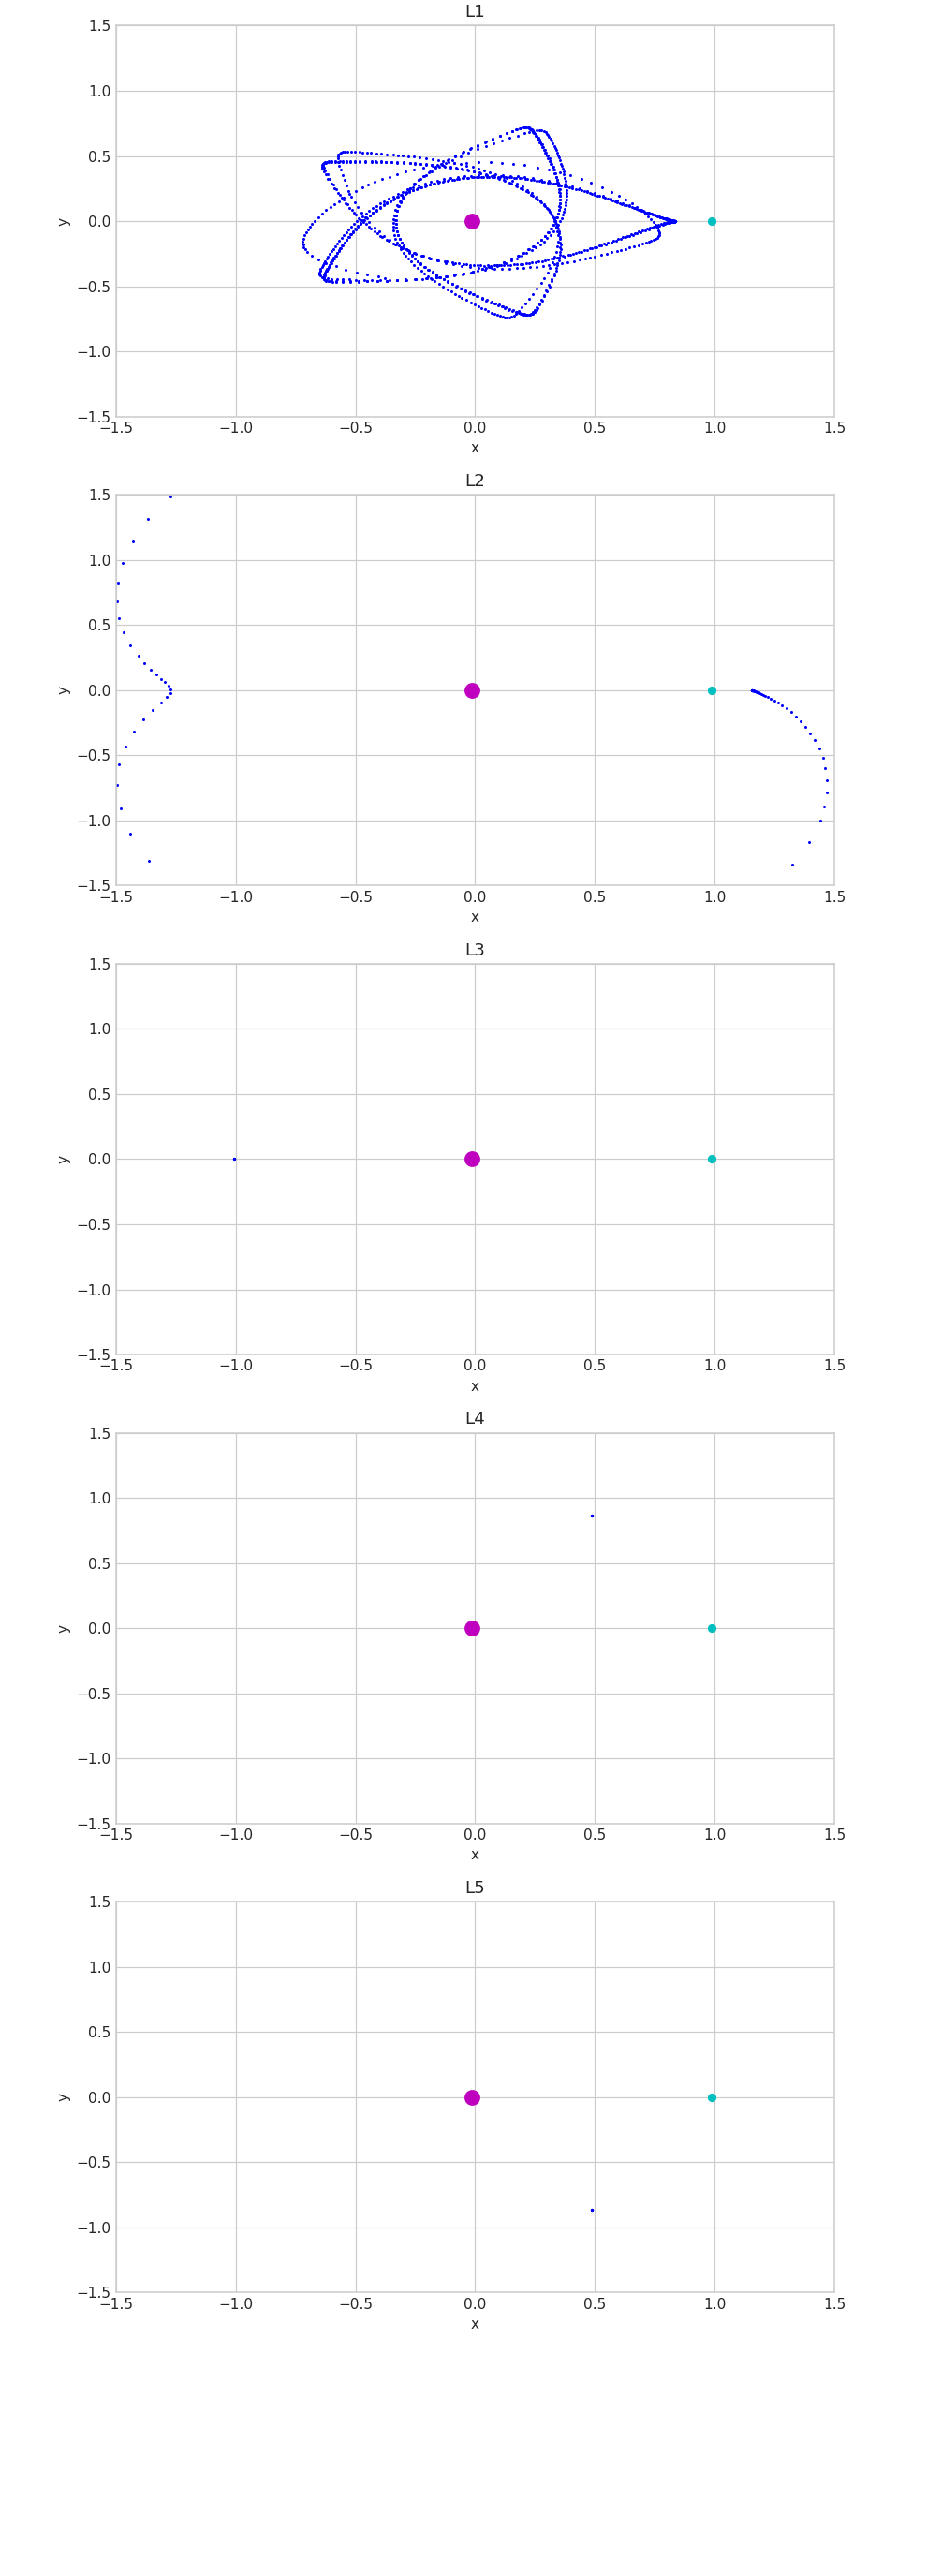

In [23]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(lagrange_st0),figsize=(9,5*5))
fig.subplots_adjust(hspace=0.2,top=0.99)
for idx in range(len(lagrange_st0)):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('y')
    limit=1.5
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    #x_limits = (1,1.2)
    #y_limits = (-0.1,0.1)    
    ax[idx].set_xlim(x_limits)
    ax[idx].set_ylim(y_limits)
    ax[idx].plot(-alpha ,    0, 'mo', ms = 10 )
    ax[idx].plot( 1 - alpha, 0, 'co', ms = 5  )
    ax[idx].plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T,'bo', ms=1)
    ax[idx].set_title("L"+str(idx+1))  

In [28]:
# Stability of L4
l_star = EARTH_MOON['l_star']
delta_in_km=2
delta = delta_in_km/l_star
print (f'delta is {delta} and {delta_in_km} km')
lag1_st0 = [np.array([0.4878463406529436+delta,0.8660254037844386,0,0,0,0])]
n_periods = 1
tspans = [ n_periods*2*np.pi] * len(lag1_st0)
#t_eval = np.arange(0, n_periods*2*np.pi, one_day)
t_eval = None
sols = propagate_orbit(0, alpha, lag1_st0, tspans, my_dfdt, t_eval)
for idx in range(len(lag1_st0)):
    length = curve_length(sols[idx].y[:3].T)
    in_km = l_star * length
    print (f'Length of curve by L{idx+1} is {length} and {in_km} Km')

delta is 5.202913631633715e-06 and 2 km
19
Length of curve by L1 is 0.0001071066594809911 and 41.17179990449298 Km


<IPython.core.display.Javascript object>


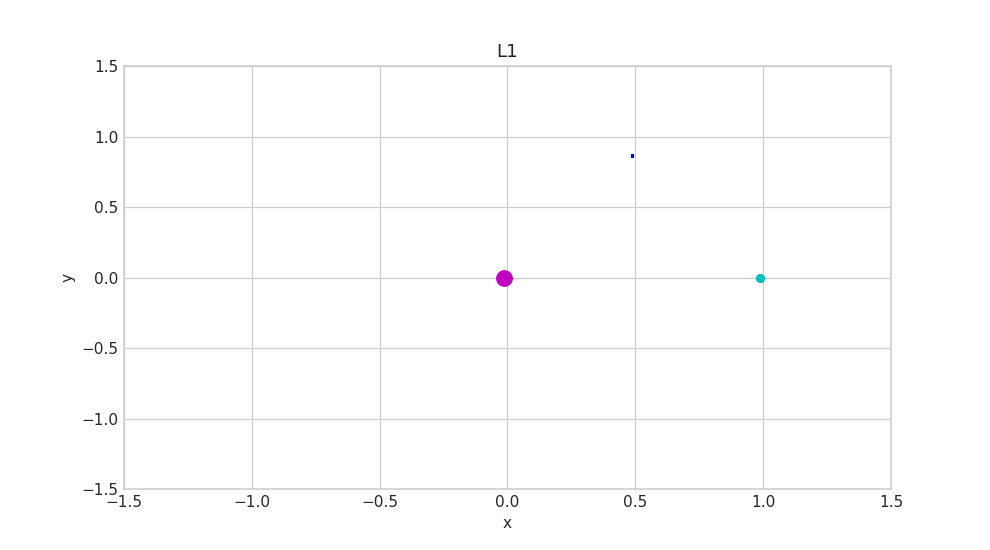

In [27]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(lag1_st0),figsize=(9,5))
for idx in range(len(lag1_st0)):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    limit=1.5
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    #x_limits = (1,1.2)
    #y_limits = (-0.1,0.1)    
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.plot(-alpha ,    0, 'mo', ms = 10 )
    ax.plot( 1 - alpha, 0, 'co', ms = 5  )
    ax.plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T,'bo', ms=1)
    ax.set_title("L"+str(idx+1))  

365
407
619
747


<IPython.core.display.Javascript object>


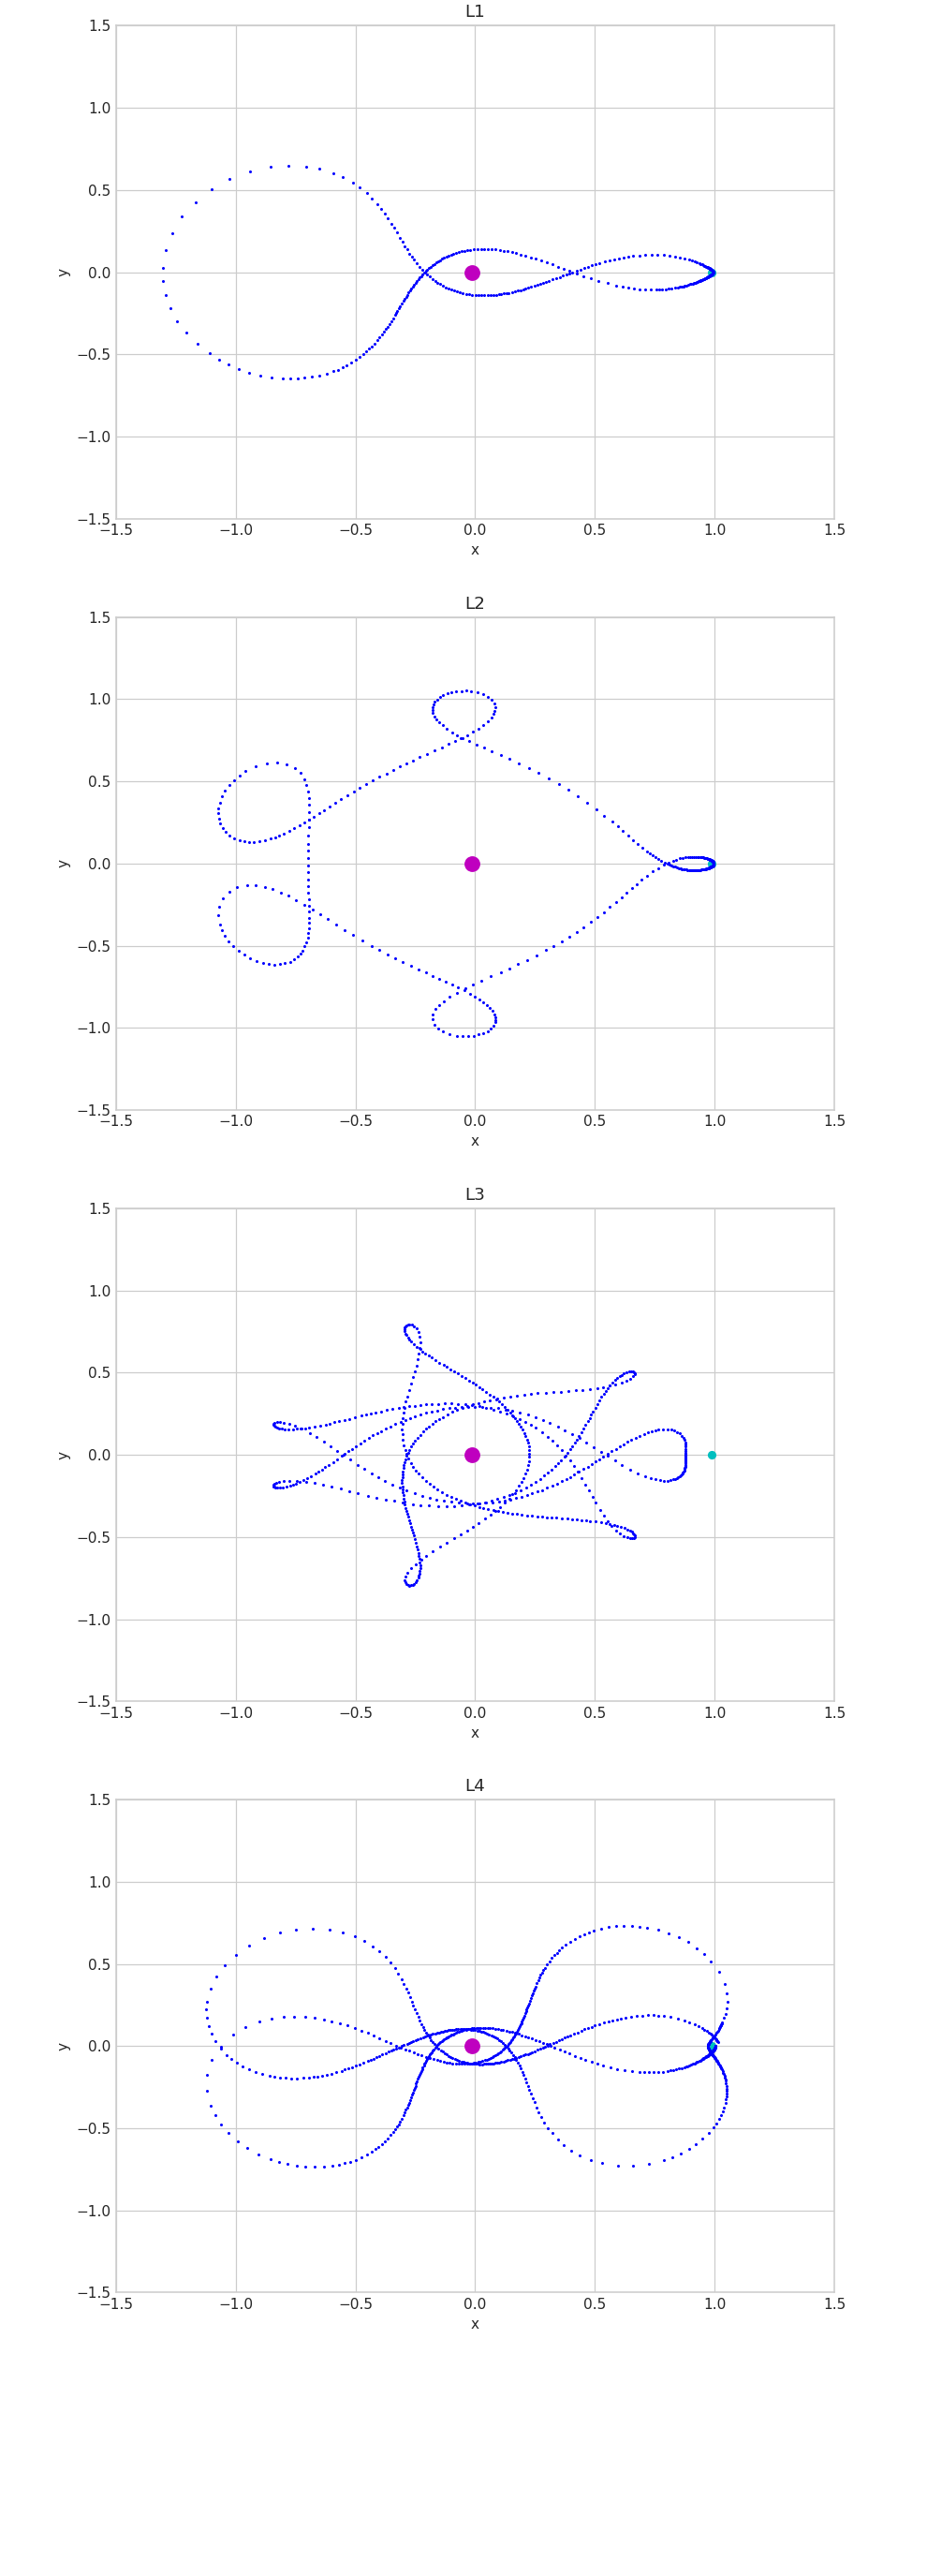

In [32]:
# Testing according to test_CR3BP.py
alpha = 0.012277471
st0 =[
    np.array([0.994,    0, 0, 0, -0.21138987966945026683e1, 0]),
    np.array([ 0.997,    0, 0, 0, -0.16251217072210773125e1, 0 ]),
    np.array([ 0.879962, 0, 0, 0, -0.38089067106386964470,   0 ]),
    np.array([ 0.1003e1, 0, 0, 0, -0.14465123738451062297e1, 0 ])
]
tspans = [0.54367954392601899690e1, 0.22929723423442969481e2,
          0.19138746281183026809e2, 0.12267904265603897140e2 ]
t_eval = None
sols = propagate_orbit(0, alpha, st0, tspans, my_dfdt, t_eval)
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(st0),figsize=(9,5*5))
fig.subplots_adjust(hspace=0.2,top=0.99)
for idx in range(len(st0)):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('y')
    limit=1.5
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    #x_limits = (1,1.2)
    #y_limits = (-0.1,0.1)    
    ax[idx].set_xlim(x_limits)
    ax[idx].set_ylim(y_limits)
    ax[idx].plot(-alpha ,    0, 'mo', ms = 10 )
    ax[idx].plot( 1 - alpha, 0, 'co', ms = 5  )
    ax[idx].plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T,'bo', ms=1)
    ax[idx].set_title("L"+str(idx+1))  

In [67]:
# With dimensions
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = EARTH_MOON['m1']
m2 = EARTH_MOON['m2']
MOON_ROTATION_PERIOD_IN_SECS=27*24*3600+7*3600+43*60+11.5
w = 2*np.pi/MOON_ROTATION_PERIOD_IN_SECS # rad/sec
mu1 = G*m1
mu2 = G*m2
t0 = 0
tf = MOON_ROTATION_PERIOD_IN_SECS*1

def dimension_dfdt(t, Y, w, mu1, mu2):   
    #print (Y)
    r_xyz = Y[0:3]
    v_xyz = Y[3:6]
    w_xyz = np.array([0,0,w])
    #print ("r->",r_xyz)
    #print ("v->",v_xyz)   
    ac1_xyz = -2*np.cross(w_xyz,v_xyz) # Coriolis 
    ac2_xyz = -np.cross(w_xyz,np.cross(w_xyz,r_xyz)) #Centrifugal 
    r13_xyz = r_xyz - np.array([-4656,0,0])
    r23_xyz = r_xyz - np.array([379344,0,0])
    ac3_xyz = -mu1*r13_xyz/np.power(np.linalg.norm(r13_xyz),3)     # gravity exerted by m1
    ac4_xyz = -mu2*r23_xyz/np.power(np.linalg.norm(r23_xyz),3)     # gravity exerted by m2
    acc_xyz = ac1_xyz+ ac2_xyz + ac3_xyz + ac4_xyz
    #print ("r-> ",r_xyz)
    #print ("v-> ",v_xyz)
    #print ("acc1->", ac1_xyz)
    #print ("acc2->", ac2_xyz)
    #print ("acc3->", ac3_xyz)
    #print ("acc4->",ac4_xyz)    
    #print ("acc->",acc_xyz)        
    return np.concatenate((v_xyz, acc_xyz))

st0 = []
#st0.append(np.array([444248.76826715656,0,0,0,0,0]))
st0.append(np.array([-386346.5733310282,0,0,0,0,0]))
#sol = solve_ivp(dimension_dfdt, (t0, tf), st0, args=(w,mu1,mu2), t_eval=None, rtol = 1e-1) 
for idx, st in enumerate(st0):
    print (f'The acceleration of L2 {dimension_dfdt(0,st,w,mu1,mu2)[3:6]}')
sol = solve_ivp(dimension_dfdt, (t0, tf), st0[0], args=(w,mu1,mu2), t_eval=None, rtol = 1e-13) 
sols=[]
sols.append(sol)

The acceleration of L2 [ 7.18867282e-09 -0.00000000e+00  0.00000000e+00]


<IPython.core.display.Javascript object>


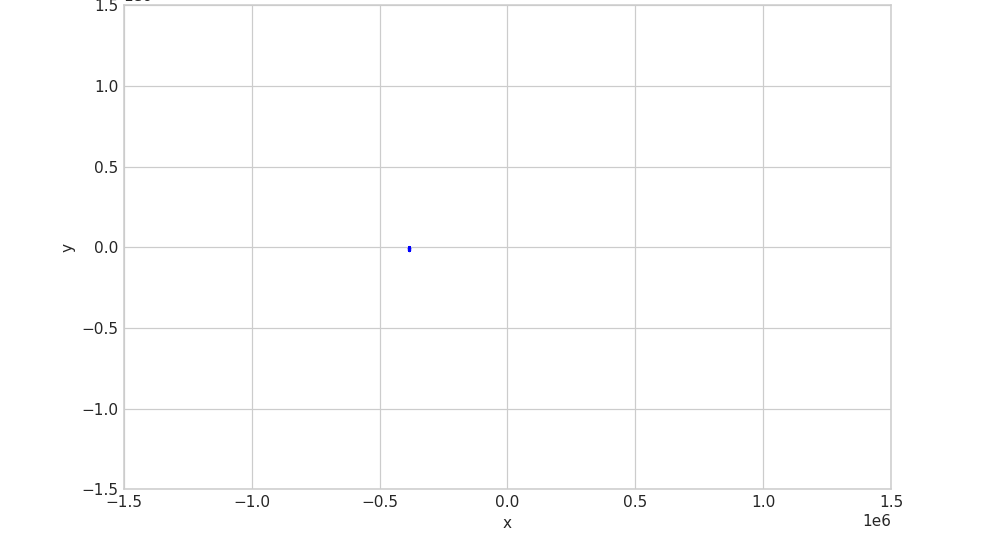

In [68]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=len(st0),figsize=(9,1*5))
fig.subplots_adjust(hspace=0.2,top=0.99)
for idx in range(len(st0)):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    limit=1500000
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    #x_limits = (1,1.2)
    #y_limits = (-0.1,0.1)    
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    #ax[idx].plot(-alpha ,    0, 'mo', ms = 10 )
    #ax[idx].plot( 1 - alpha, 0, 'co', ms = 5  )
    ax.plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T,'bo', ms=1)
    ax.set_title("L"+str(idx+1)) 

In [8]:
G = 6.6742e-20 # Km^3/Kg*s^2
alpha = EARTH_MOON['alpha']
R = EARTH_MOON['l_star']
m1 = EARTH_MOON['m1']
m2 = EARTH_MOON['m2']
r1 = np.array([-alpha*R,0])     # Earth m1 
v1 = np.array([0,0])
r2 = np.array([(1-alpha)*R,0])  # Moon  m2
v2 = np.array([0,1])
r3 = np.array([321704.3609388412,0]) # L1 m3
v3 = np.array([0,1])
r3 = np.array([444248.76826715656,0]) # L2
#r3 = np.array([-386346.5733310282,0]) # L3
#L4: 187528.1333469915 km
#L5: 187528.1333469915 km
t0 = 0  #secs
tf = 27.3 * 24 * 3600 #  1 month
Y0 = np.concatenate((r1, r2, r3, v1, v2, v3))

sol = solve_ivp(nonrotating_dfdt, (t0, tf), Y0, args=(G,m1,m2), t_eval=None, rtol = 1e-10)   
orbs={}
orbs['m1'] = sol.y[:2,:].T
orbs['m2'] = sol.y[2:4,:].T
orbs['m3'] = sol.y[4:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2'])/(m1+m2)

# With respect G
#orbs['m1'] =  orbs['m1']  - orbs['G']
#orbs['m2'] =  orbs['m2']  - orbs['G'] 
#orbs['m3'] =  orbs['m3']  - orbs['G'] 
orbs.pop('G')




array([[ 7.27473289e-13,  0.00000000e+00],
       [ 0.00000000e+00,  3.65192781e-04],
       [ 0.00000000e+00,  4.01712060e-03],
       [ 0.00000000e+00,  4.05363987e-02],
       [-7.27473289e-13,  4.05729180e-01],
       [-7.27473289e-13,  4.05765699e+00],
       [ 0.00000000e+00,  4.05769351e+01],
       [-7.27473289e-13,  1.48547863e+02],
       [-7.27473289e-13,  2.68105766e+02],
       [-7.27473289e-13,  3.96689663e+02],
       [-1.45494658e-12,  5.32696626e+02],
       [-1.45494658e-12,  6.74958481e+02],
       [-1.45494658e-12,  8.22486988e+02],
       [-1.45494658e-12,  9.74301691e+02],
       [-1.45494658e-12,  1.12929156e+03],
       [-1.45494658e-12,  1.28612015e+03],
       [-1.45494658e-12,  1.44322419e+03],
       [-1.45494658e-12,  1.59894607e+03],
       [-2.18241987e-12,  1.75175476e+03],
       [-2.18241987e-12,  1.90042862e+03],
       [-2.18241987e-12,  2.04411285e+03],
       [-2.90989316e-12,  2.18227116e+03],
       [-2.18241987e-12,  2.31459920e+03],
       [-2.

<IPython.core.display.Javascript object>


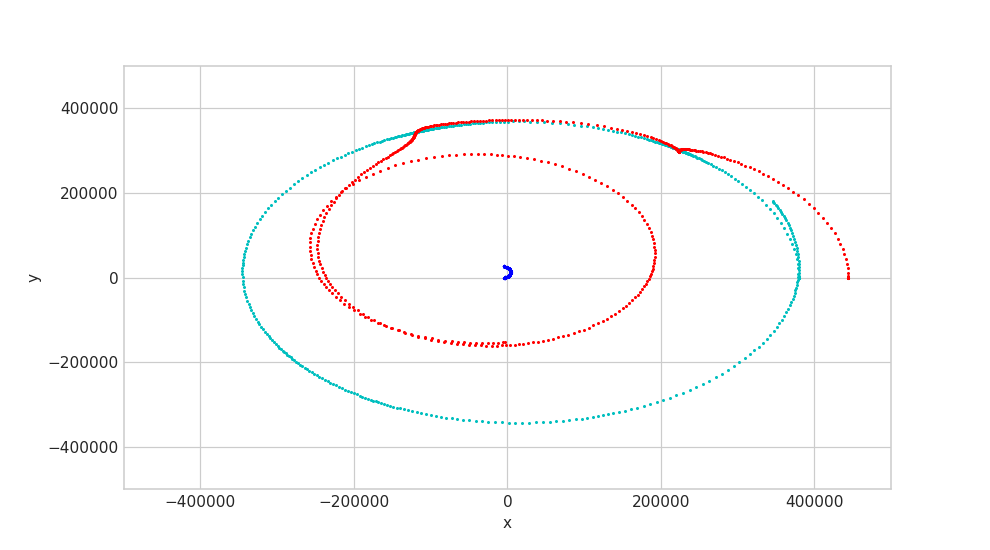

In [9]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1,figsize=(9,5))
ax.set_xlabel('x')
ax.set_ylabel('y')
limit=500000
x_limits = (-limit,limit)
y_limits = (-limit,limit)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
#ax.plot(-alpha ,    0, 'mo', ms = 10 )
#ax.plot( 1 - alpha, 0, 'co', ms = 5  )
ax.plot(orbs['m1'][:,0], orbs['m1'][:,1],'bo', ms=1)
ax.plot(orbs['m2'][:,0], orbs['m2'][:,1],'co', ms=1)
ax.plot(orbs['m3'][:,0], orbs['m3'][:,1],'ro', ms=1)


In [6]:
G = 6.6742e-20 # Km^3/Kg*s^2
alpha = EARTH_MOON['alpha']
R = 1
m1 = EARTH_MOON['m1']
m2 = EARTH_MOON['m2']
r1 = np.array([-alpha*R,0])     # Earth m1 
v1 = np.array([0,0])
r2 = np.array([(1-alpha)*R,0])  # Moon  m2
v2 = np.array([0,0.00001])
r3 = np.array([0.8369000024423547,0]) # L1 m3
v3 = v2
#r3 = np.array([1.15569398612683,0]) # L2
#r3 = np.array([-1.0050639264594907,0]) # L3
t0 = 0  #secs
tf = 27.3 * 24 * 3600 #  1 month
Y0 = np.concatenate((r1, r2, r3, v1, v2, v3))

def nonrotating2_dfdt(t, Y, m1, m2):
    x1 = Y[0:2]
    x2 = Y[2:4]
    x3 = Y[4:6]
    
    v1 = Y[6:8]
    v2 = Y[8:10]
    v3 = Y[10:12]
    
    r12__3 = np.linalg.norm(x1-x2)**3
    r23__3 = np.linalg.norm(x2-x3)**3
    r13__3 = np.linalg.norm(x1-x3)**3
    
    a1 = G*((m2*(x2-x1)/r12__3))
    a2 = G*((m1*(x1-x2)/r12__3))
    a3 = G*((m1*(x1-x3)/r13__3) + (m2*(x2-x3)/r23__3))
    #print (G*(m1*(x1-x3)/r13__3), G*(m2*(x2-x3)/r23__3), a3)
    result = np.concatenate((v1,v2,v3,a1,a2,a3))
    return result
    
sol = solve_ivp(nonrotating_dfdt, (t0, tf), Y0, args=(G,m1,m2), t_eval=None, rtol = 1e-10)   
orbs={}
orbs['m1'] = sol.y[:2,:].T
orbs['m2'] = sol.y[2:4,:].T
orbs['m3'] = sol.y[4:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2'])/(m1+m2)

# With respect G
#orbs['m1'] =  orbs['m1']  - orbs['G']
#orbs['m2'] =  orbs['m2']  - orbs['G'] 
#orbs['m3'] =  orbs['m3']  - orbs['G'] 
orbs.pop('G')




array([[-4661.80005253,     0.        ],
       [-4661.38426685,   -60.69871688],
       [-4660.13697294,  -121.38660614],
       ...,
       [  928.74045626, -4285.26329585],
       [  991.05502165, -4268.11183695],
       [ 1053.15667749, -4250.04347636]])

In [ ]:
array([[-4661.80005253,     0.        ],
       [-4661.38426685,   -60.69871688],
       [-4660.13697294,  -121.38660614],
       ...,
       [  928.74045626, -4285.26329585],
       [  991.05502165, -4268.11183695],
       [ 1053.15667749, -4250.04347636]])

In [49]:
orbs['m1']

array([[-4.67186665e+03,  0.00000000e+00],
       [-4.67186665e+03,  3.90384917e-19],
       [-4.67186665e+03,  5.19602325e-16],
       ...,
       [-4.30677291e+03,  2.67784872e+04],
       [-4.27790285e+03,  2.67842908e+04],
       [-4.25616985e+03,  2.67888098e+04]])

In [ ]:
# Changing to a non-rotating frame of reference
# Earth Moon system
m1=5.97217e24 # Earth
m2=7.34767309e22 # Moon
alpha=m2/(m2+m1)
R=384400
G = 6.6742e-20 # Km^3/Kg*s^2
m3 = 1
x1 = np.array([-4656,0])
x2 = np.array([379344,0])
# L2
L2_x = R*(1+np.cbrt(alpha/3))
L2_y = 0
L3_x = -R*(1+(5*alpha/12))
L3_y = 0
L4_x = R/2*((m1-m2)/(m1+m2))
L4_y = (np.cbrt(3)/2)*R

x3 = np.array([L3_x,L3_y])
v1 = np.array([0,0])
v2 = np.array([0,1])
v3 = np.array([-np.sqrt(2)/2,np.sqrt(2)/2])
v3 = np.array([-0.5,0.5])
v3 = np.array([0,-1])
t0 = 0 
tf = 9419200
Y0 = np.concatenate((x1, x2, x3, v1, v2, v3))


def nonrotating_dfdt(t, Y, G, m1, m2, m3):
    x1 = Y[0:2]
    x2 = Y[2:4]
    x3 = Y[4:6]
    
    v1 = Y[6:8]
    v2 = Y[8:10]
    v3 = Y[10:12]
    
    r12__3 = np.linalg.norm(x1-x2)**3
    r23__3 = np.linalg.norm(x2-x3)**3
    r13__3 = np.linalg.norm(x1-x3)**3
    
    a1 = G*((m2*(x2-x1)/r12__3))
    a2 = G*((m1*(x1-x2)/r12__3))
    a3 = G*((m1*(x1-x3)/r13__3) + (m2*(x2-x3)/r23__3))
    #print (G*(m1*(x1-x3)/r13__3), G*(m2*(x2-x3)/r23__3), a3)
    result = np.concatenate((v1,v2,v3,a1,a2,a3))
    return result
    
sol = solve_ivp(my_dfdt, (t0, tf), Y0, args=(G,m1,m2,m3), t_eval=list(range(t0,tf,5000)), rtol = 1e-10)  

In [40]:
orbs={}
orbs['m1'] = sol.y[:2,:].T
orbs['m2'] = sol.y[2:4,:].T
orbs['m3'] = sol.y[4:6,:].T
orbs['G'] =  (m1*orbs['m1']+m2*orbs['m2'])/(m1+m2)

In [25]:
def my_dfdt4(t, Y, alpha):     
    r_xyz = Y[0:3]
    v_xyz = Y[3:6]
    w_xyz = np.array([0,0,1])
    ac1_xyz = -2*(np.cross(w_xyz,v_xyz))
    ac2_xyz = -np.cross(w_xyz,np.cross(w_xyz,r_xyz))
    r13_xyz = r_xyz - np.array([-alpha,0,0])
    r23_xyz = r_xyz - np.array([1-alpha,0,0])
    ac3_xyz = -(1-alpha)*r13_xyz/(np.linalg.norm(r13_xyz)**3)
    ac4_xyz = -alpha*r23_xyz/(np.linalg.norm(r23_xyz)**3)
    acc_xyz = ac1_xyz+ ac2_xyz + ac3_xyz +  ac4_xyz
    #acc_xyz = ac3_xyz + ac4_xyz
    
    print ("r-> ",r_xyz)
    print ("v-> ",v_xyz)
    print ("acc1->", ac1_xyz)
    print ("acc2->", ac2_xyz)
    print ("acc3->", ac3_xyz)
    print ("acc4->",ac4_xyz)
    
    #print (ac1_xyz, ac2_xyz, ac3_xyz, ac4_xyz)
    return np.concatenate((v_xyz, acc_xyz))

In [30]:
my_dfdt4(0,initial_states[0], alpha)

r->  [0.83629259 0.         0.        ]
v->  [0. 0. 0.]
acc1-> [-0. -0. -0.]
acc2-> [ 0.83629259 -0.         -0.        ]
acc3-> [-1.37227208 -0.         -0.        ]
acc4-> [ 0.52916104 -0.         -0.        ]


array([ 0.        ,  0.        ,  0.        , -0.00681845, -0.        ,
       -0.        ])

In [33]:
(2*np.pi)**2*np.array([1.15616817, 0.,         0.        ])

array([45.64368984,  0.        ,  0.        ])

In [117]:
1/(2.67e-6*(24*3600*365.25))

0.01186819768315691

In [144]:
def my_dfdt3(t, Y, w, mu1, mu2):     
    r_xyz = Y[0:3]
    v_xyz = Y[3:6]
    w_xyz = np.array([0,0,w])
    #print ("r->",r_xyz)
    #print ("v->",v_xyz)
    r13_xyz = r_xyz - np.array([-4656,0,0])
    r23_xyz = r_xyz - np.array([379344,0,0])
    ac1_xyz = -2*np.cross(w_xyz, v_xyz)
    ac2_xyz = -np.cross(w_xyz, np.cross(w_xyz, r_xyz))
    ac3_xyz = -mu1*r13_xyz/(np.linalg.norm(r13_xyz)**3)
    ac4_xyz = -mu2*r23_xyz/(np.linalg.norm(r23_xyz)**3)
    acc_xyz = ac1_xyz + ac2_xyz + ac3_xyz + ac4_xyz
    print ("r-> ",r_xyz)
    print ("v-> ",v_xyz)
    print ("acc1->", ac1_xyz)
    print ("acc2->", ac2_xyz)
    print ("acc3->", ac3_xyz)
    print ("acc4->",ac4_xyz)    
    print ("acc->",acc_xyz)    
    print(r_xyz[0])
    return np.concatenate((v_xyz, acc_xyz))    

In [145]:
my_dfdt3(0,initial_states[1], w, mu1, mu2)

r->  [445656.25379473      0.              0.        ]
v->  [0. 0. 0.]
acc1-> [-0. -0. -0.]
acc2-> [ 3.08364026e-06 -0.00000000e+00 -0.00000000e+00]
acc3-> [-1.96821651e-06 -0.00000000e+00 -0.00000000e+00]
acc4-> [-1.11542375e-06 -0.00000000e+00 -0.00000000e+00]
acc-> [ 2.2324898e-15 -0.0000000e+00 -0.0000000e+00]
445656.25379473274


array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.2324898e-15,
       -0.0000000e+00, -0.0000000e+00])

In [141]:
print(np.sqrt((1.96821651e-06+1.11542375e-06)/445656.25379473274))

2.6304609016414996e-06


In [126]:
def my_dfdt2 (t, Y, mu):
    r_xyz = Y[0:3]
    v_xyz = Y[3:6]
    one_mu = 1.0 - mu
    
    r13_xyz = r_xyz - np.array([-mu,0,0])
    r23_xyz = r_xyz - np.array([one_mu,0,0])
    
    r13_3   = np.linalg.norm(r13_xyz) ** 3
    r23_3   = np.linalg.norm(r23_xyz) ** 3
    
    omega_x = r_xyz[0] - one_mu * ( r_xyz[0] + mu ) / r13_3 -mu * ( r_xyz[0] - 1 + mu ) / r23_3
    omega_y = r_xyz[1] - one_mu * r_xyz[1] / r13_3 - mu * r_xyz[1] / r23_3
    omega_z = -one_mu * r_xyz[2] / r13_3 - mu * r_xyz[2] / r23_3
    
    return np.concatenate((v_xyz, np.array([2*v_xyz[1]+omega_x, -2*v_xyz[0]+omega_y, omega_z])))

In [85]:
t0=0
sols = []
s = systems['earth-month']
for idx, Y0 in enumerate(initial_states):
    tf=tspans[idx]
    sols.append(solve_ivp(my_dfdt, (t0, tf), Y0, args=(s['alpha'],), method='LSODA', rtol= 1e-14, dense_output=False))
    #sols.append(solve_ivp(my_dfdt2, (t0, tf),  Y0,  args=(s['alpha'],) , method='LSODA', rtol= 1e-13, dense_output=False ))
    #sols.append(solve_ivp(my_dfdt3, (t0, tf), Y0, args=(w, mu1, mu2), method='LSODA', rtol= 1e-14, dense_output=False))
    print (len(sols[idx].t))

113
343
286


/home/benito/miniconda3/envs/py37_astro/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


<IPython.core.display.Javascript object>


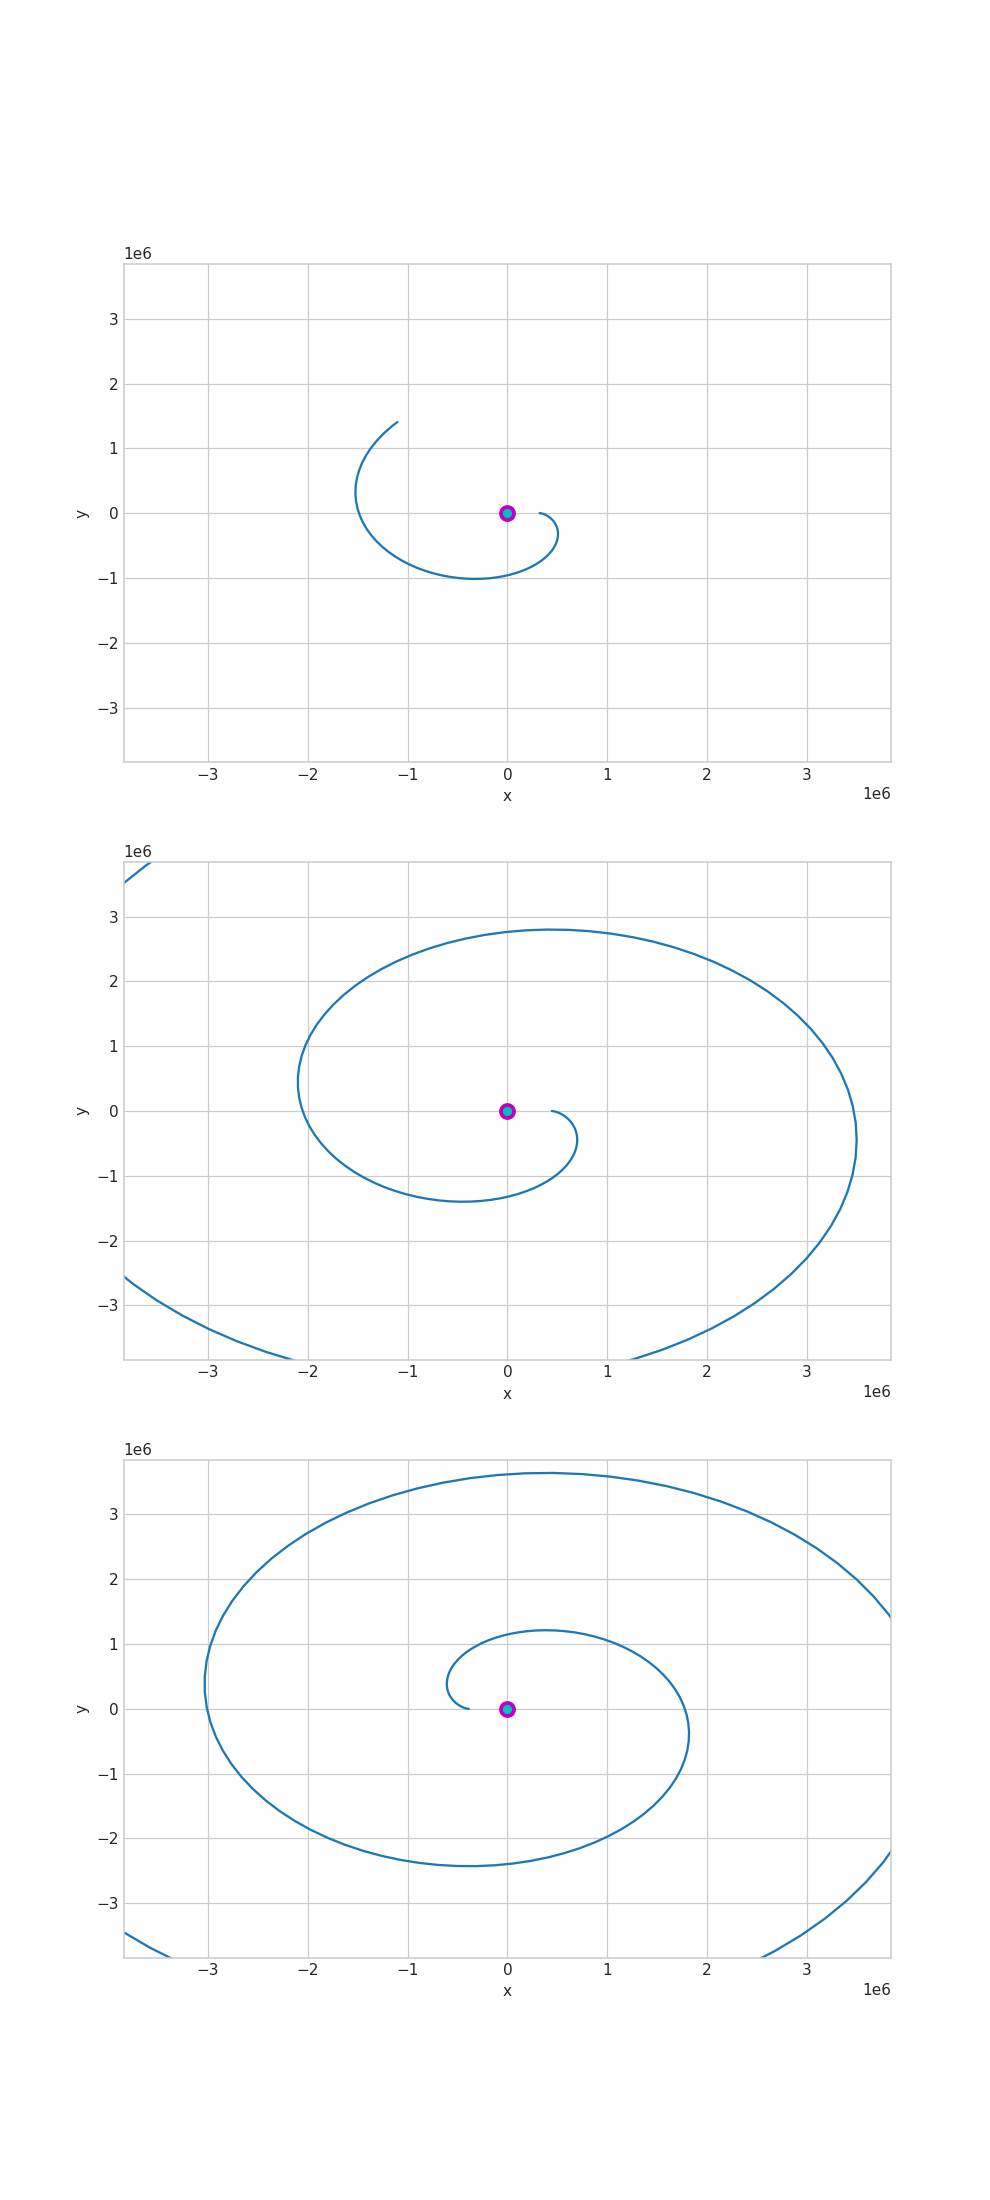

In [86]:
plt.style.use('seaborn-whitegrid')
#fig = plt.figure()
#ax = plt.a[idx]xes()
fig, ax = plt.subplots(nrows=len(initial_states),figsize=(9,5*4))
for idx in range(len(initial_states)):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel('y')
    limit=R*10
    x_limits = (-limit,limit)
    y_limits = (-limit,limit)
    ax[idx].set_xlim(x_limits)
    ax[idx].set_ylim(y_limits)
    ax[idx].plot(sols[idx].y[0:1,:].T, sols[idx].y[1:2,:].T)
    #ax[idx].plot( -4656,    0, 'mo', ms = 10 )
    #ax[idx].plot( R-4656, 0, 'co', ms = 5  )
    ax[idx].plot(-s['alpha'] ,    0, 'mo', ms = 10 )
    ax[idx].plot( 1 - s['alpha'], 0, 'co', ms = 5  )

In [77]:
print (sols[0].y[3:5,:].T)

[[ 0.00000000e+00  0.00000000e+00]
 [ 8.90153924e-16 -3.06082218e-21]
 [ 1.78030785e-15 -9.18246653e-21]
 [ 8.90813151e-12 -1.53102298e-13]
 [ 1.78337187e-11 -6.12501038e-13]
 [ 2.67978446e-11 -1.37866120e-12]
 [ 1.41936785e-10 -4.21753550e-11]
 [ 3.17712006e-10 -1.25111412e-10]
 [ 6.19866299e-10 -2.75129573e-10]
 [ 1.16973647e-09 -5.42581244e-10]
 [ 2.19272094e-09 -1.02688112e-09]
 [ 4.10974265e-09 -1.91879156e-09]
 [ 7.70923635e-09 -3.57947435e-09]
 [ 1.44700661e-08 -6.68879691e-09]
 [ 2.53732107e-08 -1.17004633e-08]
 [ 4.51238060e-08 -2.07754347e-08]
 [ 8.02335474e-08 -3.69091849e-08]
 [ 1.43910556e-07 -6.61780015e-08]
 [ 2.58080200e-07 -1.18667856e-07]
 [ 4.62811184e-07 -2.12808075e-07]
 [ 8.29847152e-07 -3.81593714e-07]
 [ 1.48795908e-06 -6.84243861e-07]
 [ 2.66798401e-06 -1.22691278e-06]
 [ 4.78379504e-06 -2.19992322e-06]
 [ 8.57755047e-06 -3.94455394e-06]
 [ 1.53800058e-05 -7.07272119e-06]
 [ 2.75772740e-05 -1.26815337e-05]
 [ 4.94485966e-05 -2.27382512e-05]
 [ 8.86687174e-05 -4

In [69]:
# Two equivalent bodys w.r.t an inertial frame of reference
orbs={}
orbs['m'] = sol.y[0:3,:].T
limit = 10
x_limits = (-limit,limit)
y_limits = (-limit,limit)
plotter = OrbitPlotter2D(orbs, x_limits, y_limits, sol.t)
plotter.start(interval=250)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
# Two bodys 
G = 6.6742e-20 # Km^3/Kg*s^2
m1 = m2 = 1e26
#m2 = 1e10

# Initial position and velocity vectors of m1
r0_xyz_m1 = np.array([0,0,0])
#v0_xyz_m1 = np.array([10,20,30])
#v0_xyz_m1 = np.array([0,0,0])
# Initial position and velocity vectors of m2
r0_xyz_m2 = np.array([3000,0,0])
#r0_xyz_m2 = np.array([0,384000,0])
v0_xyz_m2 = np.array([0,40,0])
#v0_xyz_m2 = np.array([0,5,0])
Y0 = np.concatenate((r0_xyz_m1, r0_xyz_m2, v0_xyz_m1, v0_xyz_m2))
t0 = 0
tf = 480

def my_dfdt(t, Y, G, m1, m2):     
    """ Y is the state vector
    my_dfdt is the time derivative of the state vector (r_xyz,v_xyz) which can be expressed as a function of the
    the state vector and the time since the aceleration can be expressed as function of the r(t), i.e.,
    as function of the state vector.
    
    Parameters
    ----------
    t : [type]
        [description]
    Y : [type]
        [description]
    G : [type]
        [description]
    m1 : [type]
        [description]
    m2 : [type]
        [description]

    Returns
    -------
    [type]
        [description]    
    """
    r1_xyz = Y[0:3]
    r2_xyz = Y[3:6]
    v1_xyz = Y[6:9]
    v2_xyz = Y[9:12]
    r_3  = np.linalg.norm(r2_xyz-r1_xyz)**3
    acc1_xyz = G*m2*(r2_xyz - r1_xyz)/r_3
    acc2_xyz = G*m1*(r1_xyz - r2_xyz)/r_3
    return np.concatenate((v1_xyz, v2_xyz, acc1_xyz, acc2_xyz))

sol = solve_ivp(my_dfdt, (t0, tf), Y0, args=(G,m1,m2), t_eval=list(range(0,480,4)), rtol = 1e-5)  
print (sol.y.shape)